In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Import data from yahoo
df =web.DataReader('AAPL', data_source='yahoo',start='2012-01-01', end='2021-04-22')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.650659
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.718646
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.859850
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.994284
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.973674
...,...,...,...,...,...,...
2021-04-16,134.669998,133.279999,134.300003,134.160004,84818500.0,134.160004
2021-04-19,135.470001,133.339996,133.509995,134.839996,94264200.0,134.839996
2021-04-20,135.529999,131.809998,135.020004,133.110001,94812300.0,133.110001


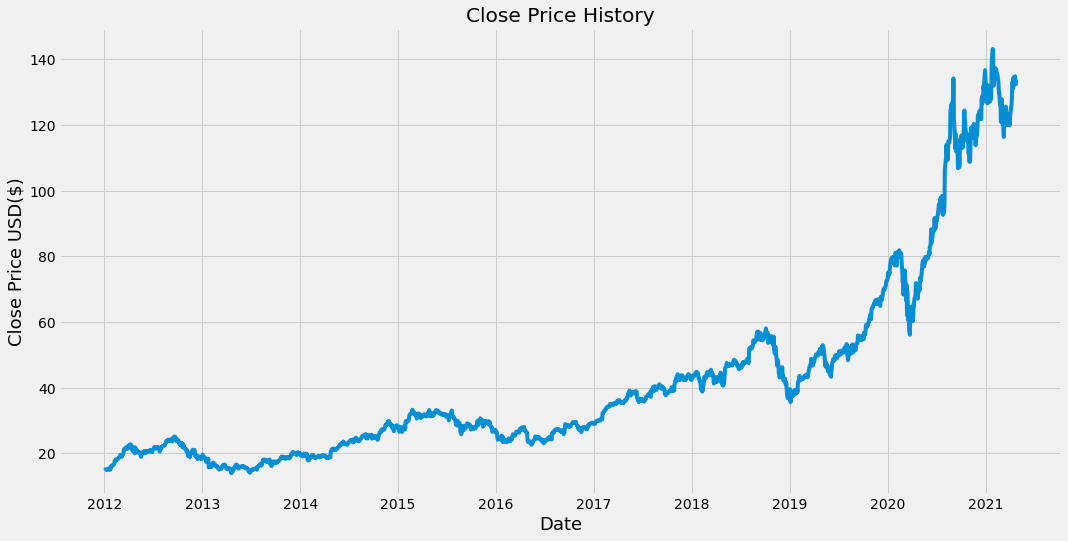

In [3]:
#Visualize data
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.show()

In [4]:
#Spit train and test data
data =df.filter(['Close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len


1873

In [5]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00572147],
       [0.00633231],
       [0.00760099],
       ...,
       [0.92222113],
       [0.9252394 ],
       [0.91316629]])

In [6]:
#Ceart the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    

In [7]:
#converting to array
x_train, y_train =np.array(x_train),np.array(y_train)


In [8]:
#Reshape data for LSTM
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


In [9]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
#compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [11]:
#Train the model
model.fit(x_train,y_train,batch_size=1,epochs=1)

1813/1813 [==============================] - 30s 16ms/step - loss: 1.8268e-04


In [12]:
#create the testing data set
#create a new array having scaled values from index 1543 to 2003
test_data=scaled_data[training_data_len-60:,:]
#create the data set x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    


In [13]:
#Test data preparation
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [14]:
# prediction
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)


In [15]:
#root mean squared error 
rmse= np.sqrt(np.mean(prediction - y_test)**2)
rmse

0.7168346144195296

c:\users\user\anaconda3\envs\stock\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


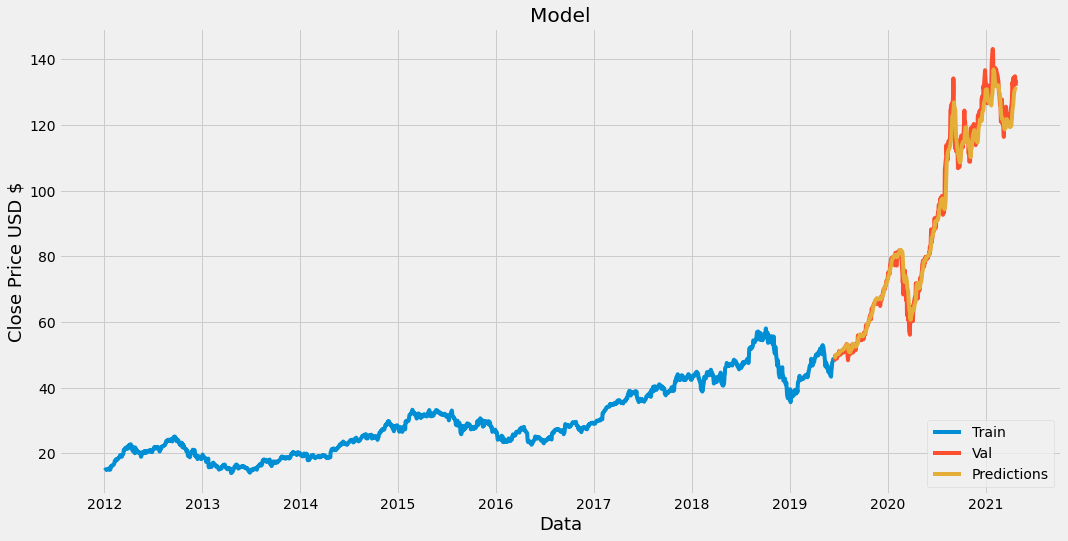

In [16]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Prediction']=prediction

#Visulaization
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Data',fontsize=18)
plt.ylabel('Close Price USD $', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Prediction']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()

In [17]:
valid

,Close,Prediction
Date,,
2019-06-14,48.185001,48.862747
2019-06-17,48.472500,49.132732
2019-06-18,49.612499,49.281776
2019-06-19,49.467499,49.509483
2019-06-20,49.865002,49.716850
...,...,...
2021-04-16,134.160004,130.285538
2021-04-19,134.839996,130.744049
2021-04-20,133.110001,131.106598


In [25]:
#Predict price from last 60 days price
apple_quote = web.DataReader('AAPL', data_source='yahoo',start='2012-01-01',end='2021-04-28')
new_df = apple_quote.filter(['Close'])
last_60_days= new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test =np.array(X_test)
#sys.exit()

X_test= np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[130.32393]]


In [26]:
X_test.shape[1]

60

In [27]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo',start='2021-04-26',end='2021-04-27')
print(apple_quote2['Close'])

Date
2021-04-26    134.559998
Name: Close, dtype: float64
